In [59]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [49]:
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [50]:
imgSize = 224

In [51]:
X = []
Y = []
hmap = {'Viral Pneumonia': 'Pneumonia', 'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    X.append(image)
    Y.append(hmap[label])
    

100%|██████████| 2905/2905 [00:45<00:00, 64.45it/s]


In [52]:
print('Covid-19:',Y.count('Covid-19'))
print('Normal:',Y.count('Normal'))
print('Pneumonia: ',Y.count('Pneumonia'))

Covid-19: 219
Normal: 1341
Pneumonia:  1345


In [53]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

In [54]:
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [55]:
print(len(trainY))
ntimes = 6
trainY = trainY.tolist()
for i in tqdm(range(len(trainX))):
    if (trainY[i][0] == 1):
        trainX += [trainX[i]]*ntimes
        trainY += [trainY[i]]*ntimes
        
trainY = np.array(trainY)

print(len(trainY))

100%|██████████| 2324/2324 [00:00<00:00, 465544.11it/s]

2324
3374


In [10]:
trainX = np.array(trainX).astype('float16')/255

testX = np.array(testX).astype('float16')/255

In [11]:
trainAug = ImageDataGenerator(rotation_range=20, horizontal_flip = True,fill_mode="nearest")

In [12]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model.h5')

# MODEL

In [13]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Train model

In [17]:
INIT_LR = 3e-4
EPOCHS = 50
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
              ],
    epochs=EPOCHS)

Train for 105 steps, validate on 581 samples
Epoch 1/50
105/105 [==============================] - 37s 357ms/step - loss: 0.1181 - accuracy: 0.9605 - val_loss: 0.1400 - val_accuracy: 0.9566
Epoch 2/50
105/105 [==============================] - 36s 339ms/step - loss: 0.1103 - accuracy: 0.9629 - val_loss: 0.1115 - val_accuracy: 0.9514
Epoch 3/50
105/105 [==============================] - 36s 347ms/step - loss: 0.1145 - accuracy: 0.9581 - val_loss: 0.1303 - val_accuracy: 0.9531
Epoch 4/50
105/105 [==============================] - 36s 343ms/step - loss: 0.0991 - accuracy: 0.9659 - val_loss: 0.1108 - val_accuracy: 0.9601
Epoch 5/50
105/105 [==============================] - 36s 344ms/step - loss: 0.0970 - accuracy: 0.9683 - val_loss: 0.1304 - val_accuracy: 0.9549
Epoch 6/50
105/105 [==============================] - 36s 343ms/step - loss: 0.1010 - accuracy: 0.9638 - val_loss: 0.1581 - val_accuracy: 0.9497
Epoch 7/50
105/105 [==============================] - 36s 339ms/step - loss: 0.0892 -

<Figure size 1440x1440 with 0 Axes>

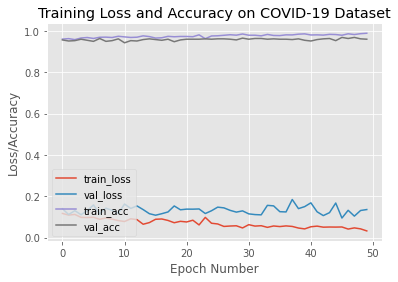

<Figure size 1440x1440 with 0 Axes>

In [34]:
N = EPOCHS
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch Number")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.figure(figsize=(20,20))

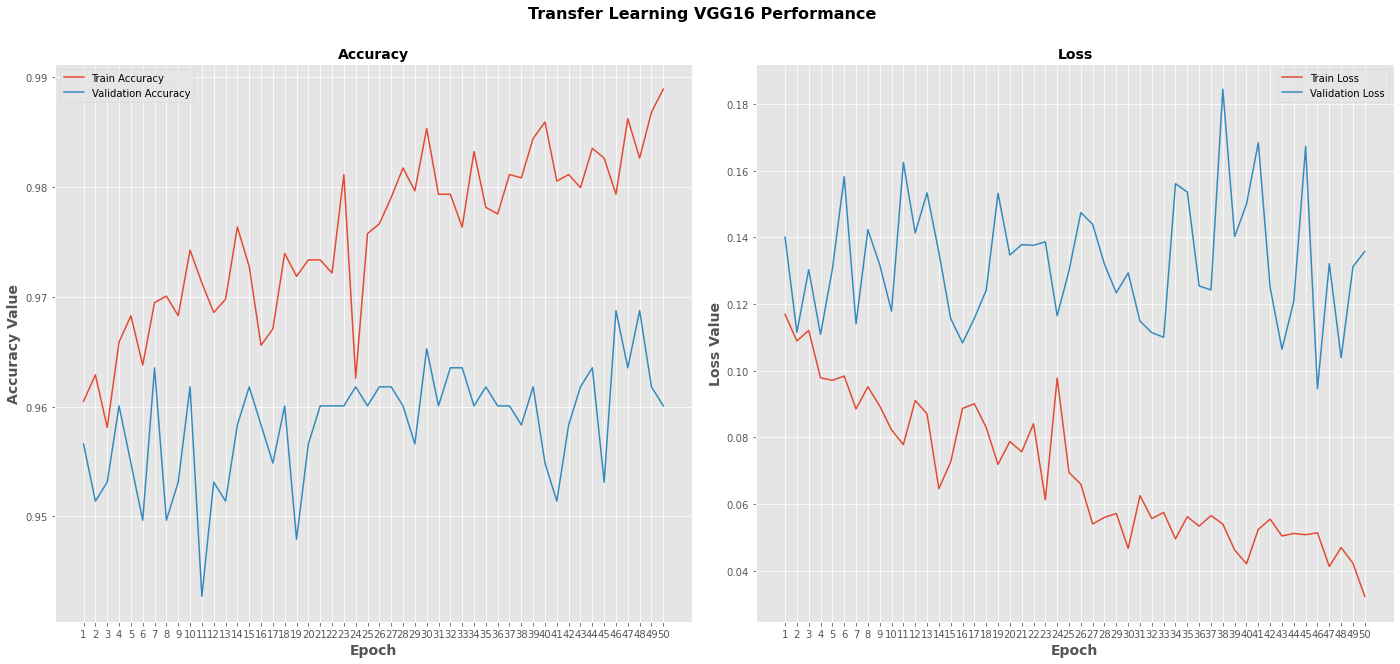

In [35]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle('Transfer Learning VGG16 Performance', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(H.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, H.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, H.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

# Load best model

In [19]:
model= load_model('model.h5')

# Result on train

In [20]:
predIdxs = model.predict(trainX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    1.00000   1.00000   1.00000      1225
      Normal    0.99626   0.99348   0.99487      1073
   Pneumonia    0.99351   0.99628   0.99490      1076

    accuracy                        0.99674      3374
   macro avg    0.99659   0.99659   0.99659      3374
weighted avg    0.99674   0.99674   0.99674      3374



# Result on test

In [21]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.93333   0.95455   0.94382        44
      Normal    0.96667   0.97388   0.97026       268
   Pneumonia    0.97744   0.96654   0.97196       269

    accuracy                        0.96902       581
   macro avg    0.95915   0.96499   0.96201       581
weighted avg    0.96913   0.96902   0.96905       581



<function matplotlib.pyplot.show(*args, **kw)>

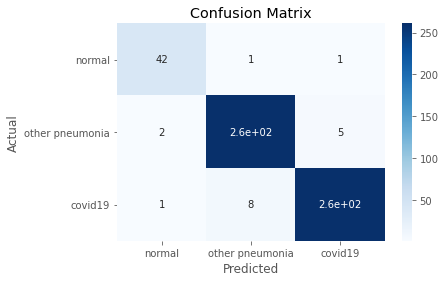

In [46]:
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
pred = model.predict(testX)
pred=np.argmax(pred,axis=1)
# pred = model.predict_classes(X_test)
Y_TEST = np.argmax(testY, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'other pneumonia', 'covid19']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [65]:
img_size = (224,224)
dir_name = '../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'
img_list = glob.glob(dir_name + '/*')

list_covid = []
for img in img_list:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_covid.append(temp_img_array)
list_covid = np.array(list_covid)
list_covid2 = list_covid.reshape(-1,50176)
df_covid=pd.DataFrame(list_covid2)
df_covid['label'] = np.full(df_covid.shape[0],2)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [66]:
img_size = (224,224)
dir_name2 = '../input/covid19-radiography-database/COVID-19 Radiography Database//NORMAL'
img_list2 = glob.glob(dir_name2 + '/*')

list_normal = []
for img in img_list2[:150]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_normal.append(temp_img_array)
list_normal = np.array(list_normal)
list_normal2 = list_normal.reshape(-1,50176)
df_normal=pd.DataFrame(list_normal2)
df_normal['label'] = np.full(df_normal.shape[0],0)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [67]:
img_size = (224,224)
dir_name3 = '../input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'
img_list3 = glob.glob(dir_name3 + '/*')

list_others = []
for img in img_list3[:150]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_others.append(temp_img_array)
list_others = np.array(list_others)
list_others2 = list_others.reshape(-1,50176)
df_others=pd.DataFrame(list_others2)
df_others['label'] = np.full(df_others.shape[0],1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [68]:
Df = pd.concat([df_covid, df_normal , df_others], ignore_index=True)

In [70]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PRED = to_categorical(pred)
y = Df['label'].values
# Binarize the output
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(testY[:,i], PRED[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

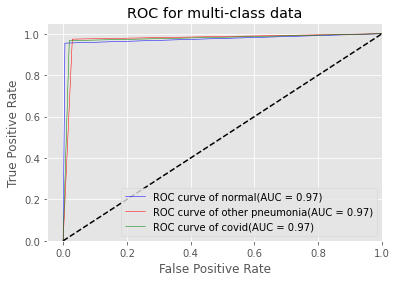

In [71]:
colors = ['blue', 'red', 'green']
cls = {0:'normal', 1:'other pneumonia', 2:'covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.5,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()